### 1. Análisis TF-IDF del Resumen y Descripción de los Bugs

In [1]:
import pandas as pd

In [2]:
file_path = "bugs_data_expanded.csv"
df_combined = pd.read_csv(file_path)

#### Sección: Preprocesamiento y Vectorización de Datos con TF-IDF

In [3]:
# Handling NaN values before vectorization
# Replace NaN values in 'Summary' and 'Description' columns with empty strings

df_combined['Summary'] = df_combined['Summary'].fillna('')
df_combined['Description'] = df_combined['Description'].fillna('')

# Combine the 'Summary' and 'Description' columns to create a single text input for TF-IDF
texts = df_combined['Summary'] + " " + df_combined['Description']

# Apply TF-IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)  # Limit to 1000 most relevant features
X_tfidf = vectorizer.fit_transform(texts)

X_tfidf.shape  # Display the shape of the resulting TF-IDF matrix


(1158, 1000)

Sección: Entrenamiento y Evaluación del Modelo k-NN
Descripción General
Este bloque de código:

Crea etiquetas binarias para la clasificación de bugs (resueltos/no resueltos).
Divide los datos en conjuntos de entrenamiento y prueba.
Entrena un modelo k-NN (k-Nearest Neighbors).
Evalúa el modelo usando métricas de clasificación.


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Creamos una etiqueta binaria de ejemplo (1 para bugs resueltos, 0 para no resueltos)
# Por ahora, puedes reemplazar 'target' con cualquier campo adecuado del dataset
y = df_combined['BugID'].apply(lambda x: 1 if 'FIX' in x else 0)  # Ejemplo simplificado

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

# Entrenamos un modelo k-NN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Realizamos predicciones y mostramos un informe de clasificación
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       348

    accuracy                           1.00       348
   macro avg       1.00      1.00      1.00       348
weighted avg       1.00      1.00      1.00       348



In [5]:
from transformers import BertTokenizer, BertModel
import torch

# Cargar el modelo y tokenizer de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Generar embeddings para cada bug
def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

# Aplicar la función para cada resumen y descripción
X_bert = [get_embedding(text) for text in texts]

# Convertir a un array de NumPy para usar en modelos de clasificación
import numpy as np
X_bert = np.array(X_bert).squeeze()

# Repetir el proceso de entrenamiento y evaluación con BERT
X_train, X_test, y_train, y_test = train_test_split(X_bert, y, test_size=0.3, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       348

    accuracy                           1.00       348
   macro avg       1.00      1.00      1.00       348
weighted avg       1.00      1.00      1.00       348



In [6]:
from sklearn.model_selection import cross_val_score

# Realizar validación cruzada con 5 folds
cv_scores = cross_val_score(knn, X_tfidf, y, cv=5)

print(f"Scores de validación cruzada: {cv_scores}")
print(f"Media de los scores: {cv_scores.mean():.2f}")


Scores de validación cruzada: [1. 1. 1. 1. 1.]
Media de los scores: 1.00


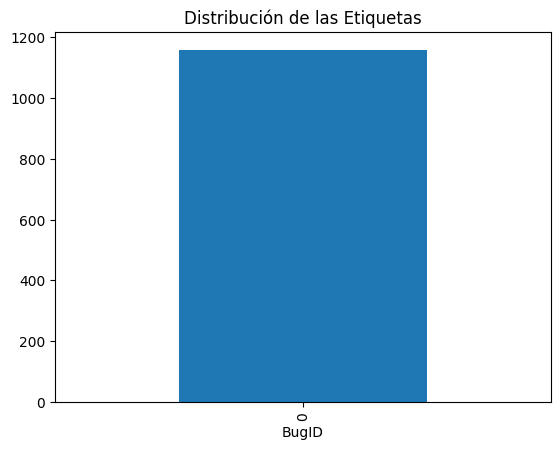

In [7]:
import matplotlib.pyplot as plt

# Ver distribución de las etiquetas
y.value_counts().plot(kind='bar')
plt.title('Distribución de las Etiquetas')
plt.show()


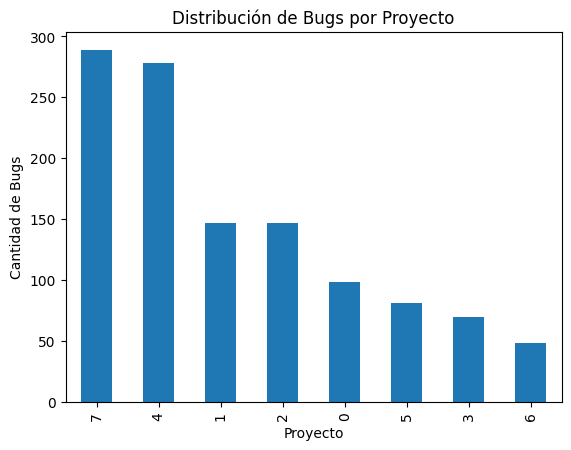

In [8]:
# Grouping bugs by project and creating labels
y_project = df_combined['project'].astype('category').cat.codes  # Encode projects as numerical labels

# Visualize the distribution of bugs per project
import matplotlib.pyplot as plt

y_project.value_counts().plot(kind='bar')
plt.title('Distribución de Bugs por Proyecto')
plt.xlabel('Proyecto')
plt.ylabel('Cantidad de Bugs')
plt.show()


In [9]:
# Dividir los datos en entrenamiento y prueba usando las nuevas etiquetas (proyectos)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_project, test_size=0.3, random_state=42)

# Entrenar un modelo k-NN con las etiquetas de proyecto
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Realizar predicciones y generar un informe de clasificación
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.52      0.48      0.50        33
           1       0.80      0.87      0.84        38
           2       0.76      0.79      0.77        52
           3       0.86      0.52      0.65        23
           4       0.83      0.84      0.83        81
           5       0.61      0.74      0.67        27
           6       1.00      0.57      0.73        14
           7       0.78      0.82      0.80        80

    accuracy                           0.76       348
   macro avg       0.77      0.71      0.72       348
weighted avg       0.77      0.76      0.76       348



In [10]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Cargar modelo y tokenizer de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Función para obtener los embeddings de BERT
def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

# Generar embeddings para todos los textos
bert_embeddings = np.array([get_embedding(text) for text in texts])

# Asegurar que los embeddings tienen la misma forma (filas) que TF-IDF
print(f"TF-IDF shape: {X_tfidf.shape}, BERT shape: {bert_embeddings.shape}")


TF-IDF shape: (1158, 1000), BERT shape: (1158, 1, 768)


In [11]:
# Adjusting the shape of BERT embeddings to match the dimensionality for concatenation
bert_embeddings_reshaped = bert_embeddings.squeeze(1)  # Remove the extra dimension

# Confirm the new shape
bert_embeddings_reshaped.shape


(1158, 768)

In [12]:
from scipy.sparse import hstack

# Convertir la matriz TF-IDF a formato denso para concatenar con BERT
X_tfidf_dense = X_tfidf.toarray()

# Concatenar TF-IDF y BERT embeddings
X_combined = np.hstack((X_tfidf_dense, bert_embeddings_reshaped))

print(f"Shape of combined feature matrix: {X_combined.shape}")


Shape of combined feature matrix: (1158, 1768)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_project, test_size=0.3, random_state=42)

# Entrenar un modelo k-NN con la combinación de TF-IDF y BERT
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = knn.predict(X_test)

# Generar y mostrar el informe de clasificación
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.44      0.33      0.38        33
           1       0.55      0.58      0.56        38
           2       0.90      0.73      0.81        52
           3       0.85      0.48      0.61        23
           4       0.61      0.72      0.66        81
           5       0.48      0.44      0.46        27
           6       0.67      0.43      0.52        14
           7       0.66      0.81      0.73        80

    accuracy                           0.64       348
   macro avg       0.64      0.57      0.59       348
weighted avg       0.65      0.64      0.64       348



In [14]:
from transformers import BertTokenizer
import torch

# Cargar el tokenizer de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Preparar los textos y las etiquetas
texts = (df_combined['Summary'] + " " + df_combined['Description']).tolist()
labels = y_project.tolist()  # Etiquetas por proyecto

# Tokenizar los textos
tokens = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Crear tensores de entrada y etiquetas
input_ids = tokens['input_ids']
attention_mask = tokens['attention_mask']
labels_tensor = torch.tensor(labels)


In [15]:
from transformers import BertForSequenceClassification

# Cargar el modelo de BERT con una capa de clasificación
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(labels)))

# Definir el optimizador y la función de pérdida
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Reentrenar k-NN con la matriz combinada (TF-IDF + BERT)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_combined, y_project)  # Entrenamiento con características combinadas

# Predicciones con la misma matriz combinada
y_pred_tfidf_bert = knn.predict(X_combined)

# Generar el informe de clasificación
from sklearn.metrics import classification_report
print("Informe de k-NN con matriz combinada:")
print(classification_report(y_project, y_pred_tfidf_bert))


Informe de k-NN con matriz combinada:
              precision    recall  f1-score   support

           0       0.72      0.77      0.74        98
           1       0.78      0.79      0.78       147
           2       0.93      0.85      0.89       147
           3       0.83      0.61      0.70        70
           4       0.80      0.90      0.84       278
           5       0.81      0.67      0.73        81
           6       0.92      0.75      0.83        48
           7       0.84      0.87      0.86       289

    accuracy                           0.82      1158
   macro avg       0.83      0.78      0.80      1158
weighted avg       0.82      0.82      0.82      1158



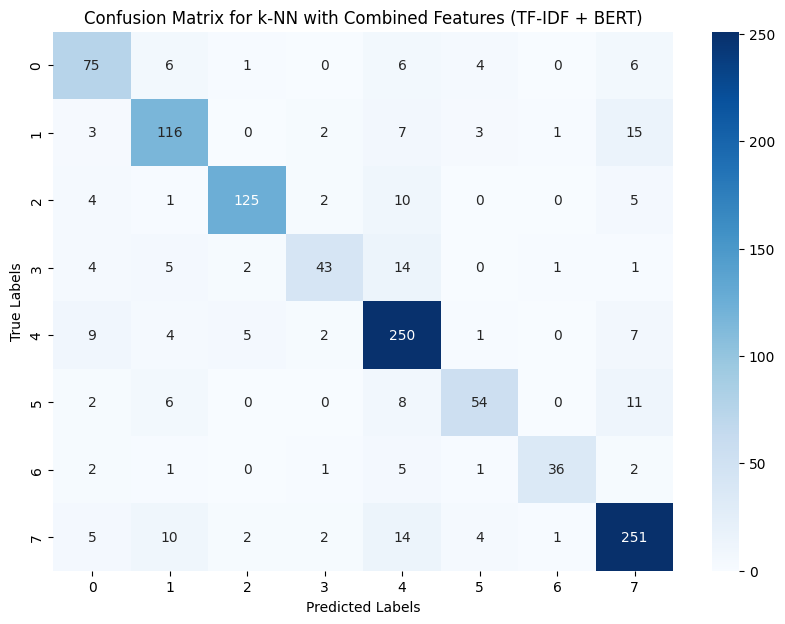

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generar la matriz de confusión
cm = confusion_matrix(y_project, y_pred_tfidf_bert)

# Crear un heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for k-NN with Combined Features (TF-IDF + BERT)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


c:\Users\NW\AppData\Local\Programs\Python\Python312\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


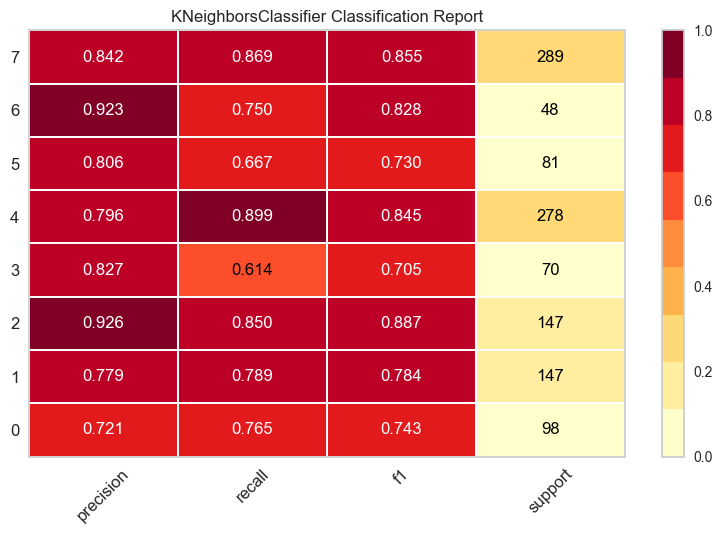

<Axes: title={'center': 'KNeighborsClassifier Classification Report'}>

In [21]:
from yellowbrick.classifier import ClassificationReport

# Crear visualizador para el informe de clasificación
visualizer = ClassificationReport(knn, support=True)
visualizer.score(X_combined, y_project)
visualizer.show()


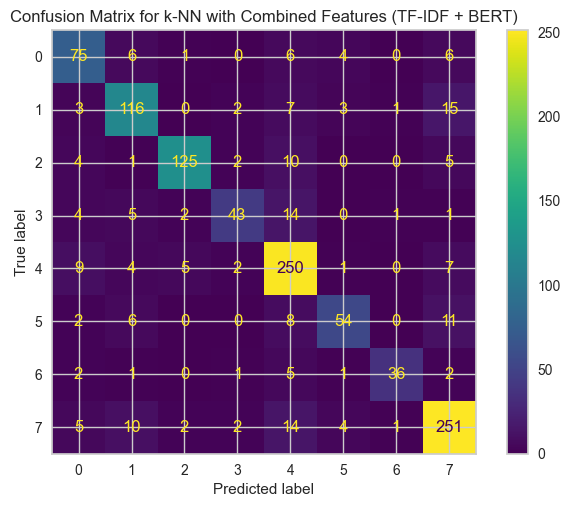

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Mostrar matriz de confusión
ConfusionMatrixDisplay.from_estimator(knn, X_combined, y_project)
plt.title("Confusion Matrix for k-NN with Combined Features (TF-IDF + BERT)")
plt.show()


### Graficas

In [ ]:
# Let's load the newly uploaded file, which may contain more structured data, possibly including date information for temporal analysis.
# I will load and examine the contents of this new file to see what visualizations we can create.
import pandas as pd
file_path_expanded = 'bugs_data_expanded.csv'
bugs_data_expanded = pd.read_csv(file_path_expanded)
bugs_data_expanded.head()


,project,branch,BugID,Summary,Description
0,accumulo,bugs-dot-jar_ACCUMULO-1044_9396979b,ACCUMULO-1044,bulk imported files showing up in metadata aft...,Bulk import fails. The file is moved to the f...
1,accumulo,bugs-dot-jar_ACCUMULO-1044_ea2f9856,ACCUMULO-1044,bulk imported files showing up in metadata aft...,Bulk import fails. The file is moved to the f...
2,accumulo,bugs-dot-jar_ACCUMULO-1051_25cf3ccd,ACCUMULO-1051,Authorizations has inconsistent serialization,The same set of authorizations may not seriali...
3,accumulo,bugs-dot-jar_ACCUMULO-1120_474b2577,ACCUMULO-1120,stop-all doesn't work: Error BAD_CREDENTIALS f...,{noformat}\n$ bin/accumulo admin stopAll\n2013...
4,accumulo,bugs-dot-jar_ACCUMULO-1183_742960f1,ACCUMULO-1183,ProxyServer does not set column information on...,The createScanner method uses the options from...


In [ ]:
import matplotlib as plt

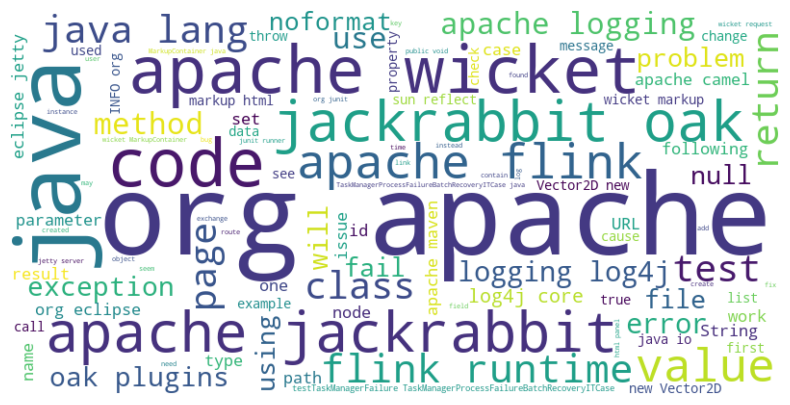

In [ ]:
# Regenerating the word cloud with corrected naming for display
import matplotlib.pyplot as plt

# Generate and display the word cloud without reusing conflicting names
plt_cloud = plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


<Figure size 1200x600 with 0 Axes>

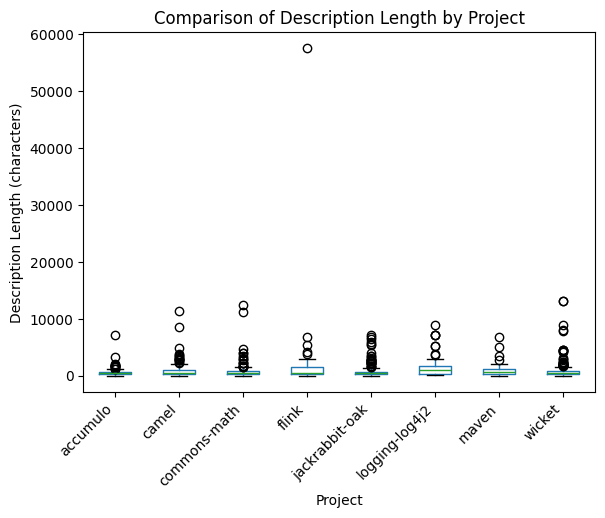

In [ ]:
# Calculating the length of each bug description to prepare for a box plot comparison by project.
bugs_data_expanded['description_length'] = bugs_data_expanded['Description'].fillna('').apply(len)

# Creating a box plot for the description length by project
plt.figure(figsize=(12, 6))
bugs_data_expanded.boxplot(column='description_length', by='project', grid=False)
plt.title('Comparison of Description Length by Project')
plt.suptitle('')  # Suppress the default title to keep it clean
plt.xlabel('Project')
plt.ylabel('Description Length (characters)')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Combine the 'Summary' and 'Description' fields to analyze word frequencies by project
bugs_data_expanded['combined_text'] = bugs_data_expanded['Summary'].fillna('') + " " + bugs_data_expanded['Description'].fillna('')

# Create a dictionary to store word frequency data by project
project_word_freq = {}

# Analyze word frequency for each project individually
for project in bugs_data_expanded['project'].unique():
    project_text = bugs_data_expanded[bugs_data_expanded['project'] == project]['combined_text']
    vectorizer = CountVectorizer(stop_words='english', max_features=10)  # Limit to top 10 words for each project
    word_counts = vectorizer.fit_transform(project_text)
    word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts.toarray().sum(axis=0)))
    project_word_freq[project] = word_freq

# Convert to a DataFrame for easier visualization
word_freq_df = pd.DataFrame(project_word_freq).fillna(0)

# Display the DataFrame to the user for review
import ace_tools_open as tools; 

tools.display_dataframe_to_user(name="Word Frequency by Project", dataframe=word_freq_df)

# Display the DataFrame structure for further analysis if needed
word_freq_df.head()


Word Frequency by Project


,accumulo,camel,commons-math,flink,jackrabbit-oak,logging-log4j2,maven,wicket
268,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
accumulo,138.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
apache,67.0,221.0,0.0,459.0,614.0,346.0,121.0,793.0
code,50.0,192.0,99.0,0.0,198.0,125.0,0.0,0.0
java,94.0,272.0,91.0,714.0,806.0,594.0,172.0,1092.0
